# Exploring and Visualizing the NYC Airbnb Market

**Dataset:** `listings.csv` from [Inside Airbnb](http://insideairbnb.com/get-the-data.html)  
**Objective:** Analyze distribution of prices, availability, and neighborhood trends in New York City.

- This notebook analyzes Airbnb listings across New York City to understand market dynamics, hosting patterns, and neighborhood-level investment potential.  
- Using cleaned listing data and aggregated performance metrics, we explore the relationship between pricing, occupancy, revenue, and ROI to identify high-value areas for hosts and investors.




## Table of Contents

1. [Importing Libraries](#import)
   
3. [Loading the Dataset](#load)

4. [Data Cleaning & Metric Engineering](#clean)
   
   - [3.1 Cleaning Price, Availability, Revenue](3.1)
   - [3.2 Computing STR Metrics (Revenue, ROI, Occupancy](3.2)
   - [3.3 Neighborhood-Level Aggregation](3.3)
   - [3.4 Display-Friendly Table Formats](3.4)


5. [Exploratory Data Analysis (EDA)](#eda)
   
   - [4.1 Distribution of Nightly Prices](4.1)
   - [4.2 ROI Distribution](4.2)
   - [4.3 Availability Trends](4.3)
   - [4.4 Room Type Supply Across Boroughs](4.4)
   - [4.5 Revenue Rankings](4.5)
   - [4.6 Correlation Across Core Investment Metrics](4.6)

6. [Investment Visualizations](#viz)
   
   - [5.1 Top Revenue Neighborhoods](5.1)
   - [5.2 Value Index](5.2) 
   - [5.3 Severe Risk Index](5.3) 

7. [3D Investment Explorer](#pm3d)
   



## 1.Importing Libraries <a id="import"></a>
Describe the essential Python libraries needed for data analysis, visualization, and clustering.



In [9]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import ipywidgets as widgets
from IPython.display import display

sns.set_style("whitegrid")

# Corporate palette — clean, professional
palette_corporate = [
    "#1f77b4",  # blue
    "#2ca02c",  # green
    "#ff7f0e",  # orange
    "#9467bd",  # purple
    "#8c564b"   # brown
]
sns.set_palette(palette_corporate)


<a id='load'></a>
## 2. Loading the Dataset
Explains:
- where the dataset comes from  
- format of the file  
- number of rows/columns  

Include: `df.head()` and `df.info()`.


In [10]:
import os
os.getcwd()


'/Users/mannalkhan/nyc_airbnb_project'

In [11]:
df = pd.read_csv("data/listings.csv")



In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt




In [13]:
import os
os.getcwd()


'/Users/mannalkhan/nyc_airbnb_project'

<a id='clean'></a>

# 3. Data Cleaning & STR Metric Computation

Cleaned data will be used for all EDA visualizations to ensure accuracy and readability.




<a id='3.1'></a>
## 3.1 Cleaning Price and Required Fields

Tasks:
- Convert `price` from strings → numeric  
- Remove impossible values  
- Ensure essential fields contain valid data  

This step prepares the dataset for realistic metric computation.




In [14]:
df_clean = df.copy()

# Clean price → numeric
df_clean["price"] = (
    df_clean["price"]
    .astype(str)
    .str.replace("$", "", regex=False)
    .str.replace(",", "", regex=False)
)

df_clean["price"] = pd.to_numeric(df_clean["price"], errors="coerce")

# Drop invalid prices
df_clean = df_clean.dropna(subset=["price"])
df_clean = df_clean[df_clean["price"] > 0]

# Clean availability
df_clean = df_clean.dropna(subset=["availability_365"])
df_clean = df_clean[(df_clean["availability_365"] >= 0) &
                    (df_clean["availability_365"] <= 365)]

# Clean neighborhood fields
df_clean = df_clean.dropna(subset=[
    "neighbourhood_group_cleansed",
    "neighbourhood_cleansed"
])

df_clean.reset_index(drop=True, inplace=True)

print("Cleaned rows:", len(df_clean))

Cleaned rows: 21328


<a id='3.2'></a>
## 3.2 Compute STR Performance Metrics 



In [15]:
df_clean["annual_revenue"] = df_clean["price"] * (365 - df_clean["availability_365"])
df_clean["roi"] = df_clean["annual_revenue"] / df_clean["price"]
df_clean["occupancy"] = 1 - (df_clean["availability_365"] / 365)

df_clean = df_clean[(df_clean["annual_revenue"] >= 0) & (df_clean["roi"] >= 0)]

<a id='3.3'></a>
## 3.3 Neighborhood-Level Aggregation

We compute for each neighborhood:

- Median nightly price  
- Median annual revenue  
- Median ROI (%)  
- Median occupancy rate  
- Listing count  

We also create:
- Normalized ROI, revenue, occupancy  
- Yield Score  
- Yield Tier (High / Moderate / Low)


In [16]:
neigh_stats = (
    df_clean.groupby(["neighbourhood_group_cleansed", "neighbourhood_cleansed"])
    .agg(
        median_price=("price", "median"),
        median_roi=("roi", "median"),
        median_occupancy=("occupancy", "median"),
        median_revenue=("annual_revenue", "median"),
        count=("price", "count")
    )
    .reset_index()
)

print(neigh_stats.head())

  neighbourhood_group_cleansed neighbourhood_cleansed  median_price  \
0                        Bronx               Allerton          90.0   
1                        Bronx             Baychester          95.0   
2                        Bronx                Belmont          78.5   
3                        Bronx              Bronxdale          58.5   
4                        Bronx            Castle Hill         140.0   

   median_roi  median_occupancy  median_revenue  count  
0        63.0          0.172603          5200.0     37  
1       104.5          0.286301          7056.0     14  
2         7.5          0.020548           407.0     16  
3        84.5          0.231507          3968.0     12  
4        63.5          0.173973          8530.5      8  


In [17]:
neigh_stats_display = neigh_stats.copy()

neigh_stats_display["Annual Revenue ($)"] = neigh_stats_display["median_revenue"].apply(
    lambda x: f"${x:,.0f}"
)

neigh_stats_display["ROI (%)"] = neigh_stats_display["median_roi"].apply(
    lambda x: f"{x:,.1f}%"
)

neigh_stats_display["Occupancy Rate (%)"] = neigh_stats_display["median_occupancy"].apply(
    lambda x: f"{x*100:.1f}%"
)

neigh_stats_display["Nightly Price ($)"] = neigh_stats_display["median_price"].apply(
    lambda x: f"${x:,.0f}"
)

neigh_stats_display["Listing Count"] = neigh_stats_display["count"].apply(
    lambda x: f"{x} listings"
    
)

<a id='3.4'></a>
## 3.4 Display-Friendly Table Formats

We now format price, revenue, ROI, and occupancy for tables & tooltips.


In [18]:
neigh_stats_display = neigh_stats.copy()

neigh_stats_display["Nightly Price ($)"] = neigh_stats_display["median_price"].apply(lambda x: f"${x:,.0f}")
neigh_stats_display["Annual Revenue ($)"] = neigh_stats_display["median_revenue"].apply(lambda x: f"${x:,.0f}")
neigh_stats_display["ROI (%)"] = neigh_stats_display["median_roi"].apply(lambda x: f"{x:,.1f}%")
neigh_stats_display["Occupancy (%)"] = neigh_stats_display["median_occupancy"].apply(lambda x: f"{x*100:.0f}%")
neigh_stats_display["Listing Count"] = neigh_stats_display["count"].apply(lambda x: f"{x} listings")

neigh_stats_display.head()


,neighbourhood_group_cleansed,neighbourhood_cleansed,median_price,median_roi,median_occupancy,median_revenue,count,Nightly Price ($),Annual Revenue ($),ROI (%),Occupancy (%),Listing Count
0,Bronx,Allerton,90.0,63.0,0.172603,5200.0,37,$90,"$5,200",63.0%,17%,37 listings
1,Bronx,Baychester,95.0,104.5,0.286301,7056.0,14,$95,"$7,056",104.5%,29%,14 listings
2,Bronx,Belmont,78.5,7.5,0.020548,407.0,16,$78,$407,7.5%,2%,16 listings
3,Bronx,Bronxdale,58.5,84.5,0.231507,3968.0,12,$58,"$3,968",84.5%,23%,12 listings
4,Bronx,Castle Hill,140.0,63.5,0.173973,8530.5,8,$140,"$8,530",63.5%,17%,8 listings


<a id='eda'></a>

# 4. Exploratory Data Analysis (EDA)

This EDA section examines the NYC Airbnb dataset to identify pricing behavior, demand patterns, and revenue performance across neighborhoods and boroughs.

It includes:

- Price distribution  
- ROI (Return on Investment) distribution  
- Availability trends  
- Room type supply across boroughs  
- Revenue rankings  
- Correlation across investment metrics  

Each visualization is followed by a **Key Insight** and a corresponding **Conclusion note** for your final summary section.



<a id='4.1'></a>
## 4.1 Distribution of Nightly Prices

In [19]:
import os
os.getcwd()


'/Users/mannalkhan/nyc_airbnb_project'

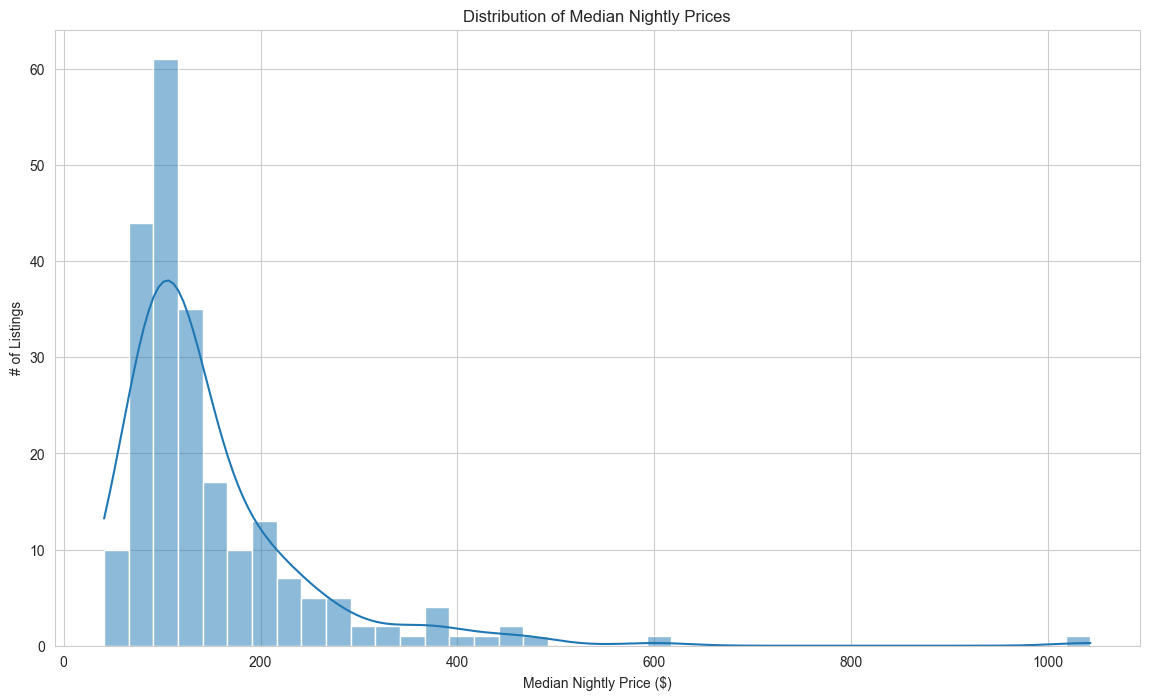

In [23]:
plt.figure(figsize=(14,8))
sns.histplot(
    neigh_stats["median_price"],
    bins=40,
    kde=True,
    color=palette_corporate[0]
)
plt.title("Distribution of Median Nightly Prices")
plt.xlabel("Median Nightly Price ($)")
plt.ylabel("# of Listings")

plt.savefig("figures/interactive/median_price_distribution.png", dpi=300, bbox_inches="tight")

plt.show()



### Key Insight: Nightly Price Distribution
- Most NYC neighborhoods cluster between 100–$250 per night.
- A small number of luxury areas push prices upward.
- This helps investors estimate expected nightly pricing across boroughs.



<a id='4.2'></a>
## 4.2 ROI Distribution Across Neighborhoods


ROI helps quantify efficiency — how much return an investor gets relative to nightly price.


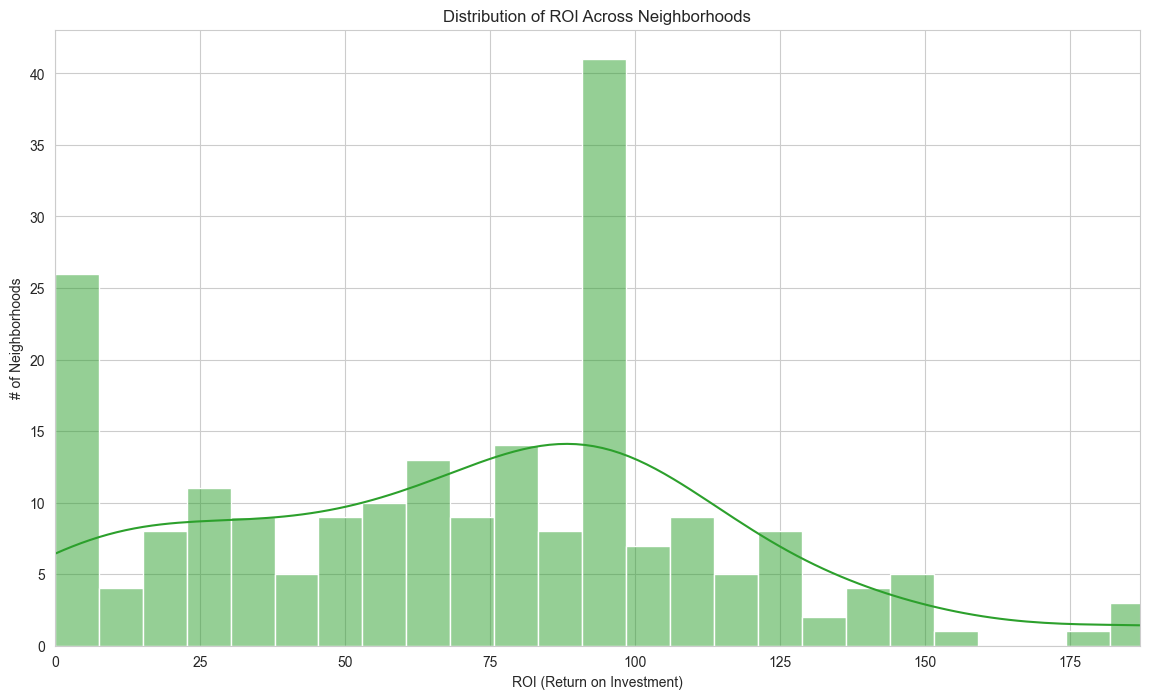

In [24]:
plt.figure(figsize=(14,8))
sns.histplot(
    neigh_stats["median_roi"],
    bins=40,
    kde=True,
    color=palette_corporate[1]
)
plt.title("Distribution of ROI Across Neighborhoods")
plt.xlabel("ROI (Return on Investment)")
plt.ylabel("# of Neighborhoods")
plt.xlim(0, neigh_stats["median_roi"].quantile(0.95))

plt.savefig("figures/interactive/median_roi_distribution.png", dpi=300, bbox_inches="tight")

plt.show()



### Key Insight: ROI Distribution

- ROI skews upward because some neighborhoods offer strong occupancy at moderate prices.
- Most neighborhoods fall into a moderate-yield range.
- High-ROI areas are typically those with:
  - Strong year-round occupancy  
  - Lower average nightly price  
  - Steady booking demand  

This distribution helps PMs identify neighborhoods where returns outperform cost.


<a id='4.3'></a>
## 4.3 Availability Distribution (Days Unbooked per Year)


### Key Insight: Availability Distribution

- Listings cluster at two extremes:
  - **Low availability (<150 days)** → strong booking demand  
  - **High availability (>250 days)** → softer demand or oversupply
- Availability is one of the clearest signals of **market demand strength**.


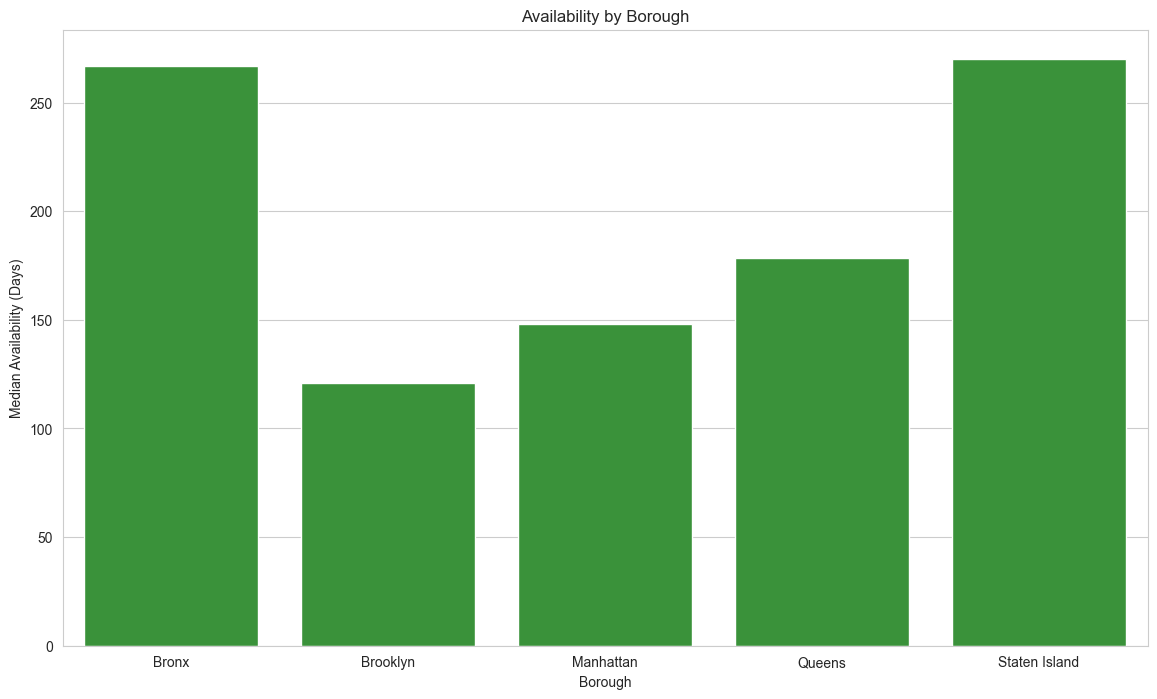

In [25]:
borough_avail = df.groupby('neighbourhood_group_cleansed')['availability_365'].median().reset_index()

plt.figure(figsize=(14,8))
sns.barplot(
    data=borough_avail,
    x='neighbourhood_group_cleansed',
    y='availability_365',
    color=palette_corporate[1]  # muted green
)
plt.title("Availability by Borough")
plt.xlabel("Borough")
plt.ylabel("Median Availability (Days)")

plt.savefig("figures/interactive/availibility_distribution.png", dpi=300, bbox_inches="tight")
plt.show()


### Key Insight: Availability Distribution

- Listings cluster at two extremes:
  - **Low availability (<150 days)** → strong booking demand  
  - **High availability (>250 days)** → softer demand or oversupply
- Availability is one of the clearest signals of **market demand strength**.


<a id='4.4'></a>
## 4.4 Room Type Distribution by Borough


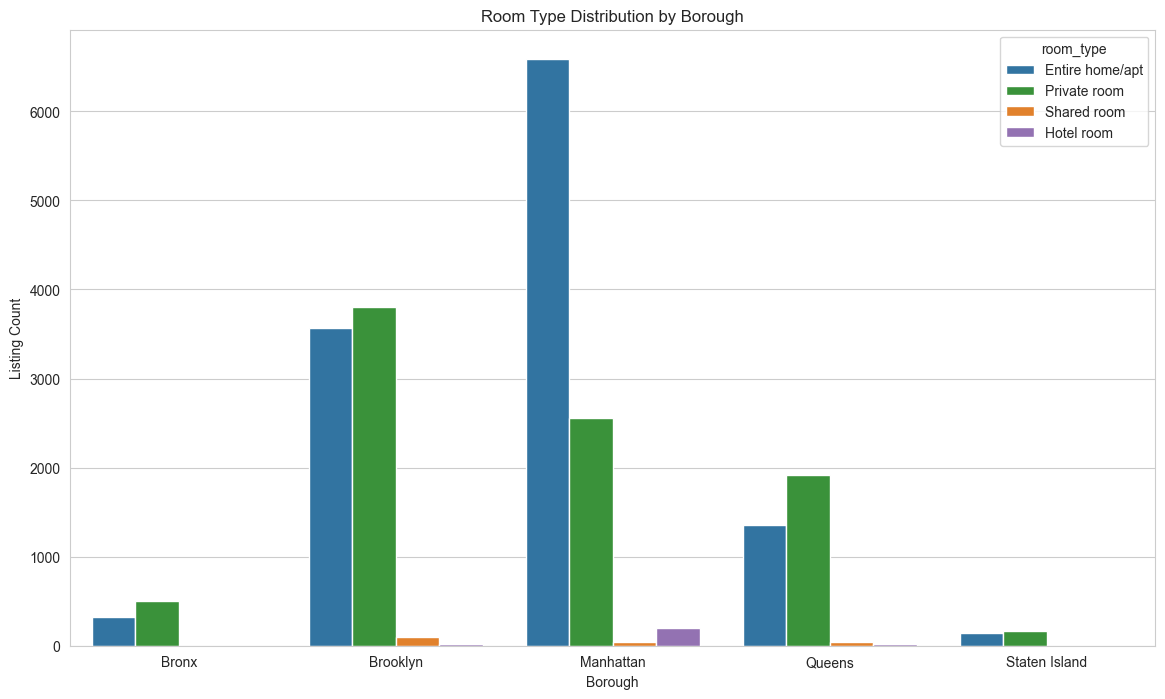

In [26]:
room_counts = df_clean.groupby(["neighbourhood_group_cleansed", "room_type"]).size().reset_index(name="count")

plt.figure(figsize=(14,8))
sns.barplot(
    data=room_counts,
    x="neighbourhood_group_cleansed",
    y="count",
    hue="room_type"
)
plt.title("Room Type Distribution by Borough")
plt.xlabel("Borough")
plt.ylabel("Listing Count")
plt.savefig("figures/interactive/room_type_by_borough", dpi=300, bbox_inches="tight")
plt.show()

### Key Insight: Room Types by Borough

- Entire-home listings dominate **Manhattan and Brooklyn**, aligning with tourism-heavy demand.
- Queens, Bronx, and Brooklyn lean toward **private rooms**, reflecting different traveler segments.
- Supply type shapes both pricing strategy and occupancy behavior.


<a id='4.5'></a>
## 4.5 Highest and Lowest-Revenue Neighborhoods


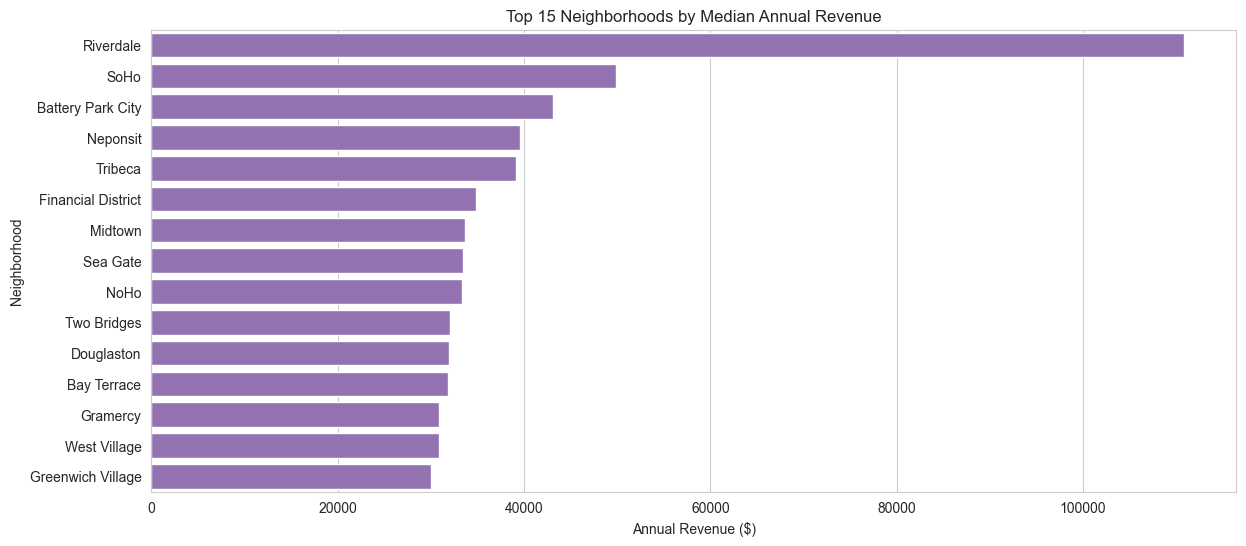

In [27]:
top_rev = neigh_stats.sort_values("median_revenue", ascending=False).head(15)

plt.figure(figsize=(14,6))
sns.barplot(
    data=top_rev,
    x="median_revenue",
    y="neighbourhood_cleansed",
    color=palette_corporate[3]
)
plt.title("Top 15 Neighborhoods by Median Annual Revenue")
plt.xlabel("Annual Revenue ($)")
plt.ylabel("Neighborhood")
plt.savefig("figures/interactive/highest_and_lowest_revenue_neighborhoods", dpi=300, bbox_inches="tight")

plt.show()



### Key Insight: Top Revenue Neighborhoods

- High performers combine **steady occupancy + competitive pricing**.
- Low performers tend to have **softer demand** or room-type limitations.
- This ranking helps shortlist candidate neighborhoods for focused investment modeling.

<a id='4.6'></a>
## 4.6 Correlation Across Core Investment Metrics


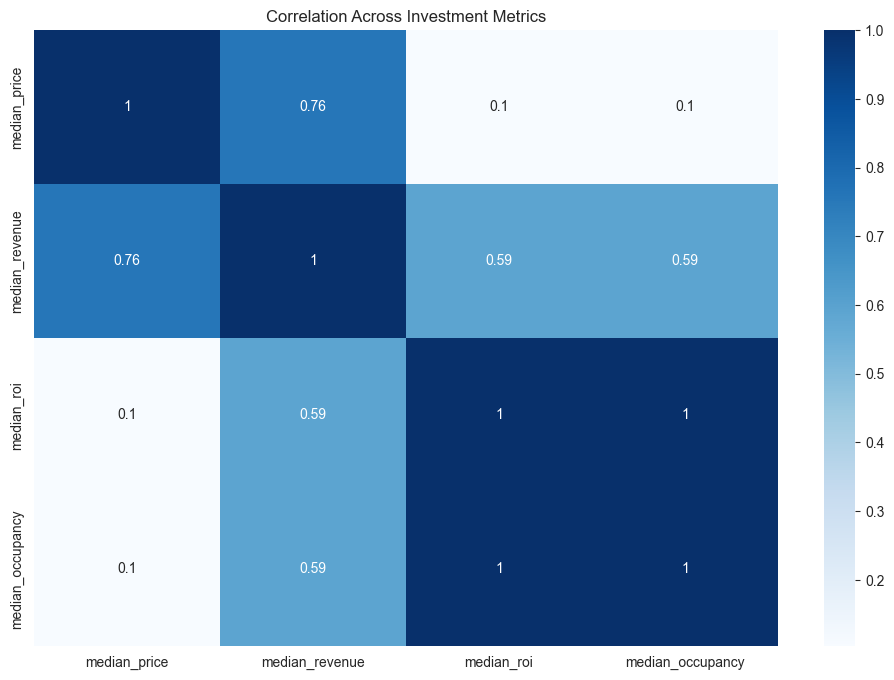

In [28]:
corr = neigh_stats[["median_price", "median_revenue", "median_roi", "median_occupancy"]].corr()

plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True, cmap="Blues")
plt.title("Correlation Across Investment Metrics")

plt.savefig("figures/interactive/correlation_map", dpi=300, bbox_inches="tight")
plt.show()

### Key Insight: Correlation Map
- Revenue correlates strongly with occupancy.
- ROI correlates strongly with revenue efficiency.
- Price does NOT strongly predict ROI—value is driven by demand, not cost.

<a id='viz'></a>

# 5. Investment Visualizations

*This section presents clear, decision-oriented investment visuals tailored for product managers, analysts, and stakeholders.*

The goal of Section 5 is to answer core investment questions:

- Which neighborhoods generate strong revenue?
- How does ROI vary within and across boroughs?
- Where do severe investment risks exist?


<a id='5.1'></a>

## 5.1 Demand Index (Occupancy × Revenue)

The Demand Index measures how strongly guests prefer each neighborhood by combining:
- **Median Occupancy Rate** (how often listings get booked)
- **Median Annual Revenue** (how much they earn)

Together, these reflect true *market demand* rather than price alone.  
Use the dropdown to explore top-performing neighborhoods by borough.


In [31]:
import ipywidgets as widgets 

boroughs = sorted(neigh_stats["neighbourhood_group_cleansed"].unique())

def plot_demand_index(borough, save=False):
    subset = neigh_stats[neigh_stats["neighbourhood_group_cleansed"] == borough].copy()
    subset["demand_index"] = subset["median_occupancy"] * subset["median_revenue"]
    subset = subset.sort_values("demand_index", ascending=False).head(15)

    plt.figure(figsize=(12, 8))
    sns.barplot(
        data=subset,
        x="demand_index",
        y="neighbourhood_cleansed",
        color=palette_corporate[2]
    )
    plt.title(f"Top 15 Neighborhoods by Demand Index — {borough}")
    plt.xlabel("Demand Index (Occupancy × Revenue)")
    plt.ylabel("Neighborhood")
    plt.grid(axis="x", alpha=0.3)

    if save:
        plt.savefig(f"demand_index_{borough.lower()}")

    plt.show()

widgets.interact(
    plot_demand_index,
    borough=widgets.Dropdown(options=boroughs, description="Borough:"),
    save=False
)


interactive(children=(Dropdown(description='Borough:', options=('Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'S…

<function __main__.plot_demand_index(borough, save=False)>

### Key Insight: Demand Leaders
- High Demand Index = neighborhoods where guests consistently choose to stay.
- These areas often sustain strong booking momentum and higher pricing power.
- Investors seeking dependable performance should prioritize high-demand markets.


<a id='5.2'></a>

## 5.2 Value Index (ROI Adjusted for Price)

The Value Index identifies neighborhoods where investors get the **strongest return per dollar spent**.

Formula:
**Value Index = Median ROI ÷ Median Price**

This reveals *undervalued opportunities* — areas with strong returns that don’t require high upfront pricing.


In [32]:
def plot_roi(borough, save=False):
    subset = neigh_stats[neigh_stats["neighbourhood_group_cleansed"] == borough]
    subset = subset.sort_values("median_roi", ascending=False).head(20)

    plt.figure(figsize=(16,6))
    sns.barplot(
        data=subset,
        x="median_roi",
        y="neighbourhood_cleansed",
        color=palette_corporate[3]
    )

    plt.title(f"Top Neighborhoods by ROI — {borough}")
    plt.xlabel("ROI (ratio)")
    plt.ylabel("Neighborhood")

    # --- Correct save block ---
    if save:
        filename = f"figures/interactive/roi_top20_{borough.lower().replace(' ', '_')}.png"
        plt.savefig(filename, dpi=300, bbox_inches="tight")
        print(f"Saved: {filename}")

    plt.tight_layout()
    plt.show()

    

In [34]:

widgets.interact(
    plot_roi,
    borough=widgets.Dropdown(options=boroughs, description="Borough:"),
    save=False
)


interactive(children=(Dropdown(description='Borough:', options=('Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'S…

<function __main__.plot_roi(borough, save=False)>

### Key Insight: Best Value Neighborhoods
- These markets deliver strong ROI without requiring high nightly prices.
- They represent efficient, cost-effective investment opportunities.
- PMs can use this ranking to identify neighborhoods with high upside at lower cost.


<a id='5.3'></a>

### **5.3 The Severe Risk Index**

The Severe Risk Index highlights neighborhoods where multiple structural weaknesses overlap, signaling elevated investment risk.  
Instead of flagging mild issues, this model identifies neighborhoods that show **several major red flags at once**, including:

- persistently low occupancy (weak demand)  
- high vacancy availability  
- low ROI performance  
- low annual revenue  
- an extremely small number of listings (market instability)




In [35]:
def compute_risk(df):
    r = df.copy()

    r["low_occ"] = (r["median_occupancy"] < 0.55).astype(int)
    r["high_avail"] = (r["median_occupancy"] < 0.40).astype(int)
    r["low_roi"] = (r["median_roi"] < 0.70).astype(int)
    r["low_revenue"] = (r["median_revenue"] < 10000).astype(int)
    r["thin_market"] = (r["count"] < 8).astype(int)

    r["risk_score"] = (
        4*r["low_occ"] +
        4*r["high_avail"] +
        3*r["low_roi"] +
        2*r["low_revenue"] +
        2*r["thin_market"]
    )

    def risk_label(x):
        if x >= 11:
            return "High Risk"
        elif x >= 6:
            return "Moderate Risk"
        return "Low Risk"

    r["Risk Tier"] = r["risk_score"].apply(risk_label)
    return r

risk_neigh = compute_risk(neigh_stats)

def plot_risk(borough, save=False):
    subset = risk_neigh[risk_neigh["neighbourhood_group_cleansed"] == borough]
    subset = subset.sort_values("risk_score", ascending=False).head(15)

    plt.figure(figsize=(14,6))
    sns.barplot(
        data=subset,
        x="risk_score",
        y="neighbourhood_cleansed",
        hue="Risk Tier",
        palette={"High Risk":"#d62728", "Moderate Risk":"#ff7f0e", "Low Risk":"#2ca02c"}
    )
    plt.title(f"Severe Risk Index — {borough}")
    plt.xlabel("Risk Score (0–15)")
    plt.ylabel("Neighborhood")

    if save:
        # FIX: must include folder AND extension
        plt.savefig(f"figures/plots/risk_index_top15_{borough.lower()}.png", dpi=300, bbox_inches='tight')

    plt.tight_layout()
    plt.show()


In [37]:

    widgets.interact(
    plot_risk,
    borough=widgets.Dropdown(options=boroughs, description="Borough:"),
    save=False
    )

interactive(children=(Dropdown(description='Borough:', options=('Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'S…

<function __main__.plot_risk(borough, save=False)>

### Key Insight: Risk Index

Because the scoring system requires **multiple failures** before classifying a neighborhood as “High Risk,”the neighborhoods that rise to the top of this chart represent **material vulnerabilities** that can impact cash flow reliability, revenue predictability, and long-term asset value.

*This visualization helps PMs and analysts:*

- avoid markets with weak demand and erratic revenue  
- distinguish between “moderate” vs. “structurally severe” risk  
- focus due diligence on boroughs with higher concentrations of red-flag neighborhoods  
- pair high-yield insights with risk insights for balanced investment decisions  


<a id='pm3d'></a>

# 6. Investment Explorers

The visualization helps answer:

- Which neighborhoods deliver the **best ROI relative to price and occupancy**?
- Where are **high-yield micro-markets** within each borough?
- How do neighborhoods compare in terms of **investment stability**?

Use the dropdown to select a borough and explore its neighborhoods.

<a id='6.1'></a>
## 6.1 Investment Assessment — Profitability Explorer

*Where returns are strongest?*

In [53]:
ns = neigh_stats.copy()

# Choose the only signal that actually varies in your dataset
roi = ns["median_roi"]

# Percentile cuts
p75 = roi.quantile(0.75)
p25 = roi.quantile(0.25)

def yield_tier_simple(x):
    if x >= p75:
        return "High Yield"
    elif x <= p25:
        return "Low Yield"
    else:
        return "Moderate Yield"

ns["yield_tier"] = ns["median_roi"].apply(yield_tier_simple)

print(ns["yield_tier"].value_counts())

import plotly.express as px   # ← FIXED
import ipywidgets as widgets
import numpy as np




yield_tier
Moderate Yield    111
High Yield         56
Low Yield          56
Name: count, dtype: int64


In [54]:
import plotly.io as pio
pio.renderers.default = "notebook"


In [60]:
import plotly.express as px
import ipywidgets as widgets
import numpy as np

# --- Colors ---
yield_colors = {
    "Low Yield": "#D62728",     # Bold Red
    "High Yield": "#1F77B4", # Blue
    "Moderate Yield": "#2CA02C"       # Green
}

# --- Hover labels ---
hovertemplate = """
<b>%{customdata[0]}</b><br><br>
ROI: %{customdata[1]:.2f}<br>
Revenue: $%{customdata[2]:,.0f}<br>
Occupancy: %{customdata[3]:.1%}<br>
Listings: %{customdata[4]}<br>
Tier: <b>%{customdata[5]}</b><br>
<extra></extra>
"""

def plot_yield_3d(borough):

    subset = ns[ns["neighbourhood_group_cleansed"] == borough].copy()

    # --- Add small jitter to spread points apart visually ---
    subset["roi_j"] = subset["median_roi"] + np.random.uniform(-0.01, 0.01, len(subset))
    subset["rev_j"] = subset["median_revenue"] + np.random.uniform(-50, 50, len(subset))
    subset["occ_j"] = subset["median_occupancy"] + np.random.uniform(-0.002, 0.002, len(subset))

    # --- Prepare hover formatting ---
    subset["roi_fmt"] = subset["median_roi"]
    subset["rev_fmt"] = subset["median_revenue"]
    subset["occ_fmt"] = subset["median_occupancy"]

    fig = px.scatter_3d(
        subset,
        x="roi_j",
        y="rev_j",
        z="occ_j",
        color="yield_tier",
        color_discrete_map=yield_colors,
        hover_name="neighbourhood_cleansed",
        custom_data=[
            "neighbourhood_cleansed",
            "roi_fmt",
            "rev_fmt",
            "occ_fmt",
            "count",
            "yield_tier"
        ],
        title=f"<b>3D Yield Explorer — {borough}</b>",
        height=900
    )

    # --- Marker styling ---
    fig.update_traces(
        marker=dict(
            size=10,
            opacity=0.90,
            line=dict(width=1.8, color="black")
        ),
        hovertemplate=hovertemplate
    )

    # --- Layout, fonts, background ---
    fig.update_layout(
        scene=dict(
            xaxis_title="<b>ROI (Ratio)</b>",
            yaxis_title="<b>Revenue ($)</b>",
            zaxis_title="<b>Occupancy Rate</b>",

            # Light gray background for all 3 axes
            xaxis=dict(backgroundcolor="#F5F5F5", gridcolor="#D0D0D0"),
            yaxis=dict(backgroundcolor="#F5F5F5", gridcolor="#D0D0D0"),
            zaxis=dict(backgroundcolor="#F5F5F5", gridcolor="#D0D0D0"),
        ),
        font=dict(family="Helvetica Neue, Arial", size=15, color="#333"),
        legend_title="<b>Yield Tier</b>",
        margin=dict(l=0, r=0, t=60, b=0),
    )

    # --- Spread the points along axes for readability ---
    fig.update_layout(
        scene=dict(
            xaxis=dict(range=[subset["roi_j"].min() - 0.1, subset["roi_j"].max() + 0.1]),
            yaxis=dict(range=[subset["rev_j"].min() - 300, subset["rev_j"].max() + 300]),
            zaxis=dict(range=[subset["occ_j"].min() - 0.02, subset["occ_j"].max() + 0.02]),
        )
    )

    fig.show()
    fig.write_html("figures/interactive/3d_yield_explorer.html")

widgets.interact(
    plot_yield_3d,
    borough=sorted(ns["neighbourhood_group_cleansed"].unique())
)



interactive(children=(Dropdown(description='borough', options=('Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'St…

<function __main__.plot_yield_3d(borough)>